# Diabetes classification with Decision Tree

Predict whether a person has **any** form of diabetes (prediabetes or diabetes) using a decision tree on the BRFSS 2015 health indicators dataset.

We follow the Phase II progress report methodology: merge prediabetes + diabetes into a single positive class, handle class imbalance, and evaluate using ROC-AUC, PR-AUC, recall, F1, and accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import tree

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
)

DATA_PATH = Path("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

df = pd.read_csv(DATA_PATH)

target_col = "Diabetes_binary"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].values
y = df[target_col].values.astype(int)

print(f"Features shape: {X.shape}")
print("Class distribution (0=no diabetes, 1=any diabetes):")
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  class {cls}: {cnt} samples ({cnt / len(y):.3f} share)")

Features shape: (70692, 21)
Class distribution (0=no diabetes, 1=any diabetes):
  class 0: 35346 samples (0.500 share)
  class 1: 35346 samples (0.500 share)


In [2]:
# Stratified train/validation/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42,
)

neg_train, pos_train = np.bincount(y_train)
scale_pos_weight_train = neg_train / pos_train

neg_full, pos_full = np.bincount(y_train_full)
scale_pos_weight_full = neg_full / pos_full

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
print(f"Positive class fraction (train subset): {pos_train / (neg_train + pos_train):.3f}")
print(f"scale_pos_weight (train subset): {scale_pos_weight_train:.2f}")

Train size: 45242, Val size: 11311, Test size: 14139
Positive class fraction (train subset): 0.500
scale_pos_weight (train subset): 1.00


In [3]:
def evaluate_model(name, y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"{name} metrics (threshold={threshold:.2f}):")
    print(f"  Accuracy : {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall   : {rec:.3f}")
    print(f"  F1-score : {f1:.3f}")
    print(f"  ROC-AUC  : {roc:.3f}")
    print(f"  PR-AUC   : {pr_auc:.3f}\n")

    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))

Create grid of hyperparameters for the decision tree

In [4]:
param_grid = {'criterion' : ['gini', 'entropy'] # The function to measure the quality of a split.
              , 'max_depth' : [1, 2, 4, 6, 8, 10, None] # None means the tree can grow arbitrarily deep.
              , 'max_features' : [2, 3, 4, 8, 12, 16, 'sqrt', 'log2', None] # The number of features to consider when looking for the best split.
              , 'splitter' : ['best', 'random'] # The strategy used to choose the split at each node.
             }

Instantiate the Decision Tree model

In [5]:
model_tree = tree.DecisionTreeClassifier(random_state=42)

Perform the grid search

In [6]:
grid = GridSearchCV(
    estimator=model_tree,
    scoring='accuracy',
    cv=3,
    param_grid=param_grid,
    n_jobs=-1
)

Evaluate the model

In [7]:
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

model_tree = grid.best_estimator_
y_val_pred = model_tree.predict(X_test)

acc_dt = accuracy_score(y_test, y_val_pred)
auc_dt = roc_auc_score(y_test, y_val_pred)

print(f'Accuracy for Decision Tree: {acc_dt:.2%}')
print(f'AUC for Decision Tree: {auc_dt:.2f}')

0.7391583606497211
{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'splitter': 'best'}
Accuracy for Decision Tree: 73.62%
AUC for Decision Tree: 0.74


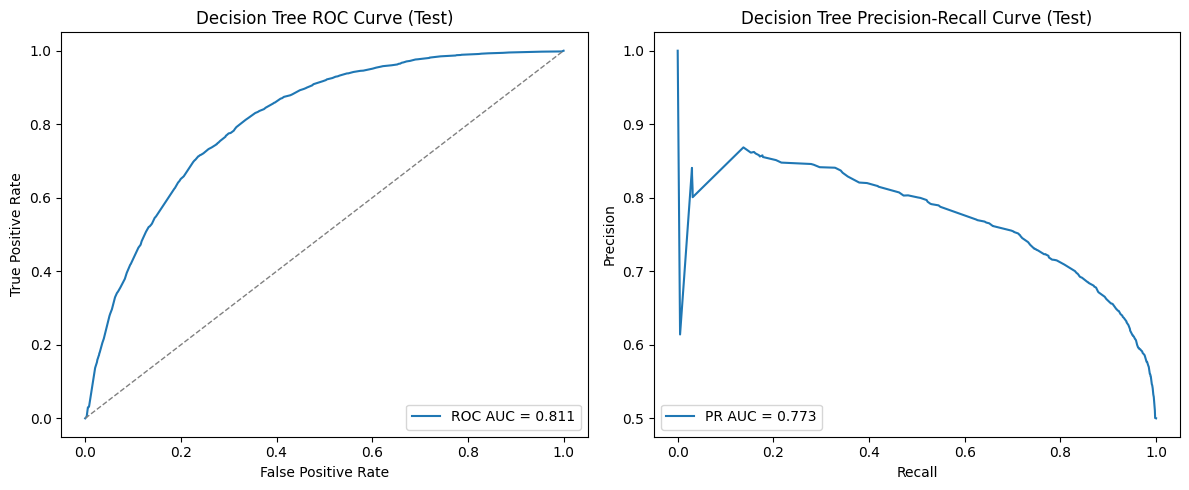

In [8]:
y_test_proba = model_tree.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
ax[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
ax[0].set_title('Decision Tree ROC Curve (Test)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
ax[1].set_title('Decision Tree Precision-Recall Curve (Test)')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.show()

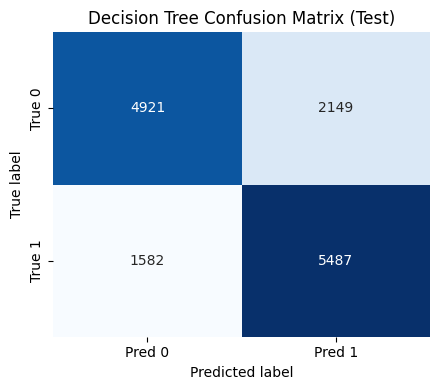

In [9]:
# Confusion matrix heatmap at tuned threshold
threshold = 0.5
dt_test_preds = (y_test_proba >= threshold).astype(int)
cm = confusion_matrix(y_test, dt_test_preds)
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
ax.set_title('Decision Tree Confusion Matrix (Test)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tight_layout()
plt.show()

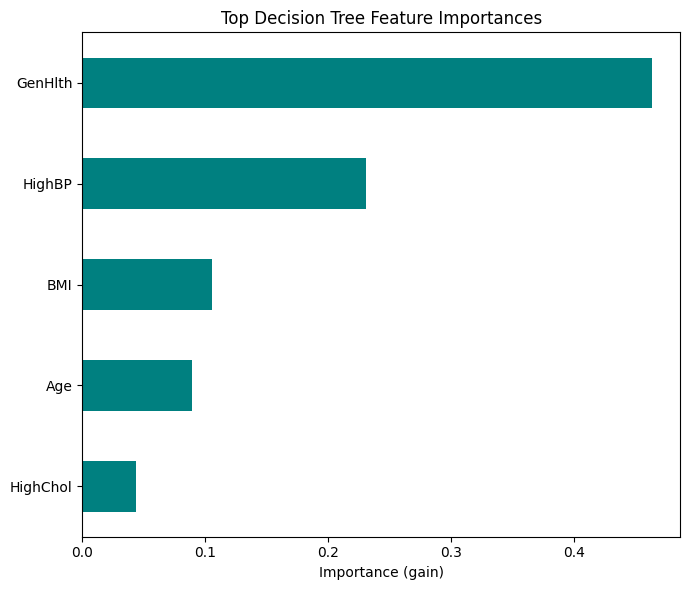

In [10]:
# Feature importance bar chart (gain-based)
importances = model_tree.feature_importances_
importance_series = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
top_k = importance_series.head(5)

plt.figure(figsize=(7, 6))
top_k.iloc[::-1].plot(kind='barh', color='teal')
plt.title('Top Decision Tree Feature Importances')
plt.xlabel('Importance (gain)')
plt.tight_layout()
plt.show()

## Correlation heatmap
Feature correlation on the balanced dataset.

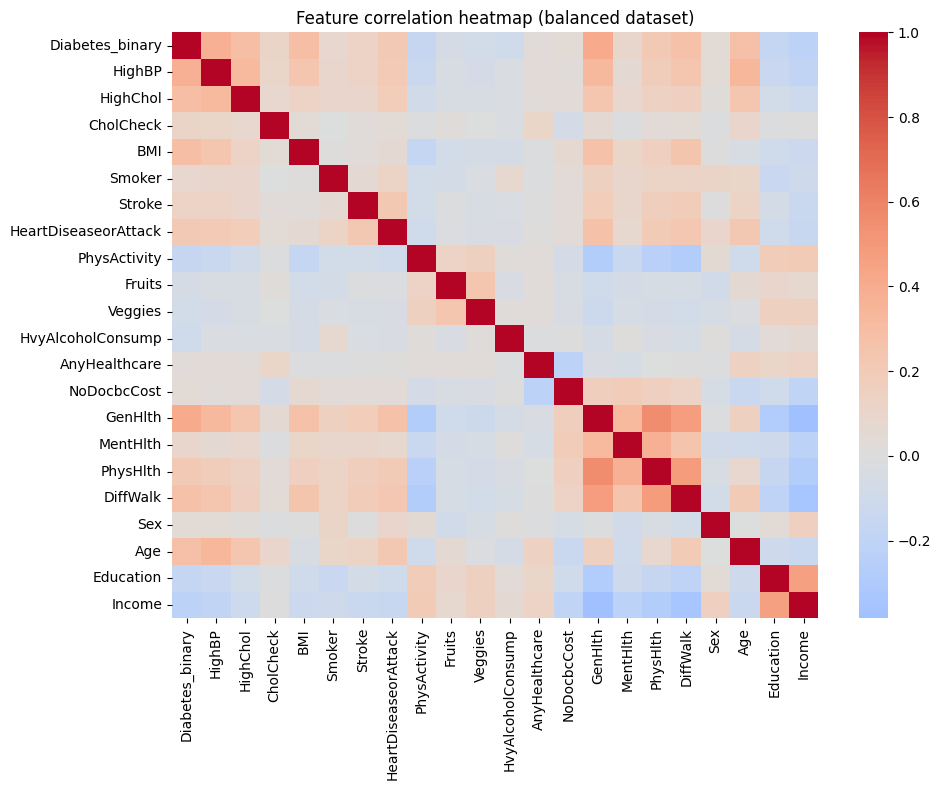

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature correlation heatmap (balanced dataset)')
plt.tight_layout()
plt.show()

## Metric summary and threshold sweep

,threshold,accuracy,precision,recall,f1,roc_auc
0,0.500000,0.736120,0.718570,0.776206,0.746277,0.811116
1,0.383673,0.729684,0.679095,0.870845,0.763109,0.811116


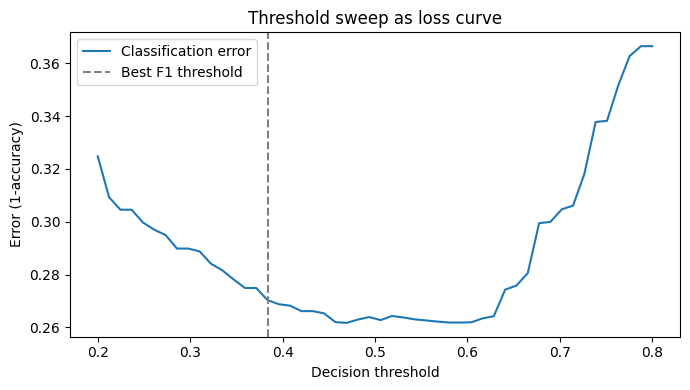

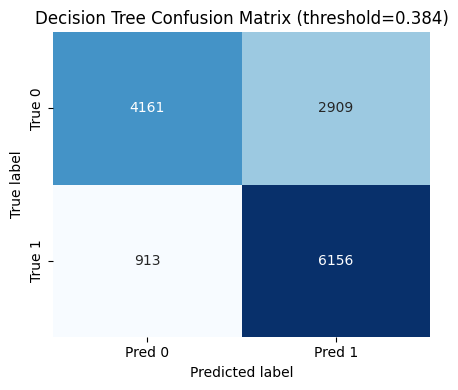

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd

threshold = 0.5
thresholds = np.linspace(0.2, 0.8, 50)
records = []
for t in thresholds:
    preds_t = (y_test_proba >= t).astype(int)
    records.append({
        "threshold": t,
        "accuracy": accuracy_score(y_test, preds_t),
        "precision": precision_score(y_test, preds_t, zero_division=0),
        "recall": recall_score(y_test, preds_t, zero_division=0),
        "f1": f1_score(y_test, preds_t, zero_division=0),
    })
metrics_df = pd.DataFrame(records)

best_row = metrics_df.loc[metrics_df['f1'].idxmax()]
best_threshold = float(best_row['threshold'])

summary = pd.DataFrame([
    {
        "threshold": threshold,
        "accuracy": accuracy_score(y_test, dt_test_preds if 'dt_test_preds' in globals() else (y_test_proba >= threshold)),
        "precision": precision_score(y_test, dt_test_preds if 'dt_test_preds' in globals() else (y_test_proba >= threshold), zero_division=0),
        "recall": recall_score(y_test, dt_test_preds if 'dt_test_preds' in globals() else (y_test_proba >= threshold), zero_division=0),
        "f1": f1_score(y_test, dt_test_preds if 'dt_test_preds' in globals() else (y_test_proba >= threshold), zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_test_proba),
    },
    {
        "threshold": best_threshold,
        "accuracy": best_row['accuracy'],
        "precision": best_row['precision'],
        "recall": best_row['recall'],
        "f1": best_row['f1'],
        "roc_auc": roc_auc_score(y_test, y_test_proba),
    },
])

display(summary)

plt.figure(figsize=(7, 4))
plt.plot(metrics_df['threshold'], 1 - metrics_df['accuracy'], label='Classification error')
plt.axvline(best_threshold, color='gray', linestyle='--', label='Best F1 threshold')
plt.xlabel('Decision threshold')
plt.ylabel('Error (1-accuracy)')
plt.title('Threshold sweep as loss curve')
plt.legend()
plt.tight_layout()
plt.show()

model_name = "Decision Tree"
cm = confusion_matrix(y_test, (y_test_proba >= best_threshold).astype(int))
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title(f'{model_name} Confusion Matrix (threshold={best_threshold:.3f})')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()